In [20]:
import qutip
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor, thermal_dm, sesolve,  ket2dm, Options, fidelity, Bloch, liouvillian)
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
def col(gamma, gamma1, gamma2):
    collapse = [np.sqrt(gamma)*sigmax(), np.sqrt(gamma1)*sigmay(), np.sqrt(gamma2)*sigmaz()]
    return collapse
collapse = col(1/24, 1/24, 1/24)

In [71]:
def hamiltonian(omega=1-0.99, Amx=0.2, Amy=0.2,wx=np.pi/2, wy=np.pi/2, g=2):
    """Two-level-system Hamiltonian

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    H0 = -0.5 * omega * sigmaz()
    H1 = sigmax()
    H2 = sigmay()

    def guess_control(t, args):
        return -1*g*Amx*np.cos(wx*t)
    def guess_control1(t, args):
        return -1*g*Amy*np.sin(wy*t)
    return [H0, [H1, guess_control],[H2, guess_control1]]

In [72]:
H = hamiltonian()

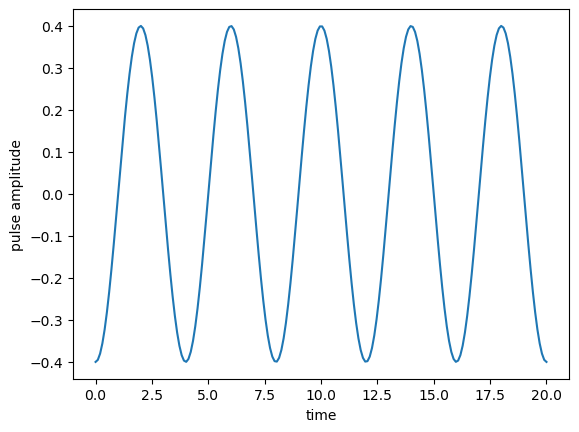

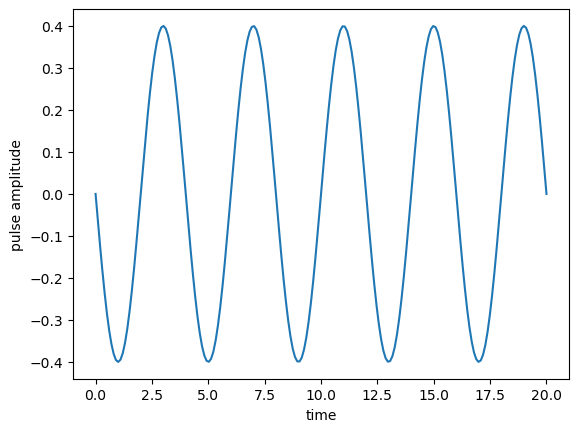

In [73]:
tlist = np.linspace(0,20, 200)

def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)
    
plot_pulse(H[1][1], tlist)
plot_pulse(H[2][1], tlist)

In [85]:
rho_0 = Qobj(np.array([[np.cos(0/2)],[np.exp(1j*0)*np.sin(0/2)]]))
rho_1 = Qobj(np.array([[np.cos(np.pi/2/2)],[np.exp(1j*np.pi)*np.sin(np.pi/2/2)]]))

objectives = [
    krotov.Objective(
        initial_state=rho_0, target=rho_1, H=H
    )
]

objectives

[Objective[|Ψ₆(2)⟩ to |Ψ₇(2)⟩ via [H₆[2,2], [H₇[2,2], u₇(t)], [H₈[2,2], u₈(t)]]]]

In [86]:
def S(t):
    if t == 0 :
        return 0.4
    elif t == 5:
        return 0.4
    else:
        return np.abs(0.2*2*np.cos((np.pi/2)*t))
def W(t):
    if t == 0 :
        return 0
    elif t == 5:
        return 0
    else:
        return np.abs(0.2*2*np.sin((np.pi/2)*t))

In [87]:
pulse_options = {
    H[1][1]: dict(lambda_a=10, update_shape=S),
    H[2][1]: dict(lambda_a=10, update_shape=W)
}

In [88]:
proj0 = qutip.ket2dm(rho_0)
proj1 = qutip.ket2dm(rho_1)
guess_dynamics = objectives[0].mesolve(tlist,c_ops=collapse,e_ops=[proj0, proj1])

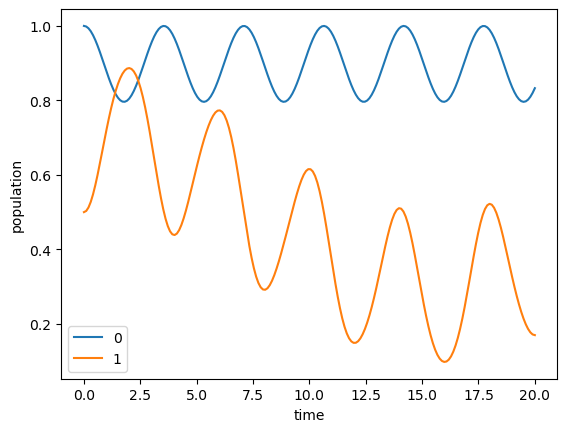

In [89]:

def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

plot_population(guess_dynamics)

In [90]:

opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True
)

iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     8.29e-01    0.00e+00   8.29e-01        n/a        n/a     3
1     7.13e-01    1.56e-03   7.15e-01  -1.16e-01  -1.14e-01     5
2     5.58e-01    2.15e-03   5.60e-01  -1.55e-01  -1.53e-01     6
3     3.87e-01    2.42e-03   3.90e-01  -1.70e-01  -1.68e-01     6
4     2.39e-01    2.17e-03   2.41e-01  -1.48e-01  -1.46e-01     7
5     1.35e-01    1.57e-03   1.36e-01  -1.04e-01  -1.03e-01     6
6     7.21e-02    9.56e-04   7.31e-02  -6.26e-02  -6.16e-02     6
7     3.79e-02    5.28e-04   3.84e-02  -3.43e-02  -3.37e-02     6
8     1.99e-02    2.79e-04   2.02e-02  -1.80e-02  -1.77e-02     6
9     1.06e-02    1.46e-04   1.07e-02  -9.34e-03  -9.20e-03     6
10    5.68e-03    7.64e-05   5.75e-03  -4.88e-03  -4.80e-03     7
11    3.10e-03    4.05e-05   3.14e-03  -2.58e-03  -2.54e-03     6
12    1.71e-03    2.18e-05   1.73e-03  -1.39e-03  -1.36e-03     6
13    9.57e-04    1.19e-05   9.69e-04  -7.55e-04  -7.43e-04     6


In [91]:
opt_result 

Krotov Optimization Result
--------------------------
- Started at 2023-12-30 13:12:09
- Number of objectives: 1
- Number of iterations: 13
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2023-12-30 13:13:37 (0:01:28)

In [92]:
optimised_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist)

print(optimised_dynamics)

Result object with sesolve data.
--------------------------------
states = True
num_collapse = 0


In [93]:

def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr, ax_ctr1,ax_dyn] = plt.subplots(nrows=3, figsize=(8, 10))
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[proj0, proj1]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_ctr1.plot(
            dynamics.times,
            controls[1],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[0],
            label=pop_labels[0],
            color='#1f77b4',  # default blue
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[1],
            label=pop_labels[1],
            color='#ff7f0e',  # default orange
            ls=ls,
            alpha=alpha,
        )
    ax_dyn.legend()
    ax_dyn.set_xlabel('time')
    ax_dyn.set_ylabel('population')
    ax_ctr.legend()
    ax_ctr.set_xlabel('time')
    ax_ctr.set_ylabel('control amplitude')
    ax_ctr1.legend()
    ax_ctr1.set_xlabel('time')
    ax_ctr1.set_ylabel('control amplitude')
    plt.show(fig)

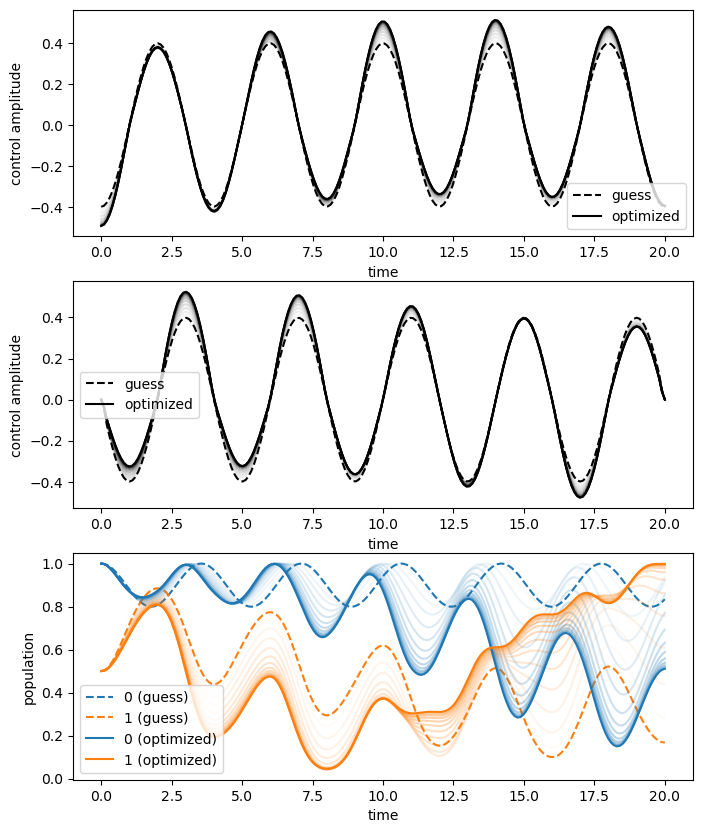

In [94]:
plot_iterations(opt_result)